In [335]:
import pyedflib
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.fft import fft
import eeglib
from scipy.signal import welch
from scipy.integrate import simps
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
import seaborn as sns
import librosa
from scipy.integrate import simps


In [2]:
from load_data import Subject_Session_Data
# from preprocess import butter_bandpass_filter

In [3]:
work_dir = os.path.dirname(os.path.dirname(os.getcwd()))
dataset_dir = os.path.join(work_dir, "enterface06_EMOBRAIN", "Data")
dataset_common_dir = os.path.join(dataset_dir, "Common")
dataset_EEG_dir = os.path.join(dataset_dir, "EEG")
dataset_fNIRS_dir = os.path.join(dataset_dir, "fNIRS")

print("working with dataset directory:", dataset_dir)

# Construct the search pattern
pattern = os.path.join(dataset_EEG_dir, "*.bdf")

# Find all files in the directory matching the pattern
bdf_files = glob.glob(pattern)

count = 1
data_list = []
for file in bdf_files:
        # Open the BDF file
        try:
                with pyedflib.EdfReader(file) as f:
                        # marks = []
                        print("reading file :", count)
                        participant_index = file.find("Part")
                        session_index = file.find("SES")
                        participant_number = int(file[participant_index+4])
                        # print("Participant number:", participant_number)
                        session_number = int(file[session_index+3])
                        # print("Session number:", session_number)
                        if participant_number == 2 and session_number == 1:
                                continue
                        fi = open(file+".mrk", "r")
                        fi.readline()
                        inferred_temp_marks = []
                        for line in fi:
                                temp_marks = line.split('\t')[1:]
                                temp_marks[-1] = temp_marks[-1][:-1]
                                if temp_marks[-1] == '"255"':
                                        if temp_marks[0] == temp_marks[1]:
                                                inferred_temp_marks.append(int(temp_marks[0]))
                                        else:
                                                print("Irregular:", temp_marks)
                        block_sample_ranges = []
                        for trigger in inferred_temp_marks:
                                if participant_number == 1 and session_number == 1:
                                        start_index = trigger + 768
                                        end_index = start_index + 3200
                                        block_sample_ranges.append((start_index,end_index))
                                else:
                                        start_index = trigger + 3072
                                        end_index = start_index + 12800
                                        block_sample_ranges.append((start_index,end_index))

                        data_list.append(Subject_Session_Data(f, count, participant_number, session_number, inferred_temp_marks, block_sample_ranges))
                        '''
                        # Get general information
                        print("reading file :", count)
                        print("File duration in seconds:", f.file_duration)
                        print("Number of signals:", f.signals_in_file)
                        signal_labels = f.getSignalLabels()
                        print("Signal labels:", signal_labels)

                        # Read data from each signal
                        for i in range(f.signals_in_file):
                                data = f.readSignal(i)
                                print(f"Data from signal {signal_labels[i]}:", data)
                        '''
        except (OSError):
                print("reading file :", count, "FAIL")
        count += 1

emotion_classes = os.path.join(dataset_common_dir, "IAPS_Classes_EEG_fNIRS.txt")
emotion_file = open(emotion_classes, "r")
session1 = []
session2 = []
session3 = []
for line in emotion_file:
        temp_emotions = line.split("\t")
        temp_emotions[-1] = temp_emotions[-1][:-1]
        session1.append(temp_emotions[0])
        session2.append(temp_emotions[1])
        session3.append(temp_emotions[2])

for subject_session in data_list:
        if subject_session.session_number == 1:
                subject_session.emotions = session1
        elif subject_session.session_number == 2:
                subject_session.emotions = session2
        elif subject_session.session_number == 3:
                subject_session.emotions = session3

working with dataset directory: /Users/magizhshankar/Documents/CS 545/Final Project/enterface06_EMOBRAIN/Data
reading file : 1
reading file : 2
reading file : 2
reading file : 3
reading file : 4
reading file : 5
reading file : 6
reading file : 7
reading file : 8
reading file : 9
reading file : 10
reading file : 11
reading file : 12
reading file : 13
reading file : 14


CALM - 0

POSITIVE - 1

NEGATIVE - 2

In [5]:
def plot_power_spectrum(freqs, psd):
    sns.set(font_scale=1.2, style='white')
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, psd, color='k', lw=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    plt.xlim([0, freqs.max()])
    sns.despine()

In [229]:
def plot_signal(data, title):
    t = np.arange(data.shape[0])
    plt.figure(figsize=(12,5))
    plt.plot(t,data)
    plt.xlim([t[0],t[-1]])
    plt.ylim([min(data), max(data)])
    plt.xlabel('time (sec)')
    plt.grid()
    plt.title(title)
    plt.show()

In [6]:
fs = 256

In [336]:
def rf(x_train, y_train, x_test, y_test, depth):
    rf = RandomForestClassifier(max_depth=depth, random_state=3)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [340]:
def knn(x_train, y_train, x_test, y_test, neighbors):
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    classifier = neigh.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [465]:
############################################################ ASSERTING INTERESTED CHANNELS ARE IN ALL THE DATA READINGS ############################################################

# Interested signals refers to the channels used to extract features
interested_signals = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
count = 0
for i in range(len(data_list)):
    try:
        for signal in interested_signals:
            count += 1
            assert signal in data_list[i].signal_labels
    except:
        print("Yeah")
count

448

In [466]:
# all_signals has the keys as the interested channels and the values as the interested channels' samples across all data. There are 420 truncation regions 
# across our dataset and for each truncation region we have 3200 samples for each interested channel
all_signals = {}
for signal in interested_signals:
    all_signals[signal] = np.zeros((420, 3200))

In [467]:
# Storing the labels of all 420 truncation regions
all_signals_labels = np.zeros(420)
emotion_to_number_dict = {'Calm' : 0, 'Pos': 1, 'Neg' : 2}


# Populating all_signals dictionary. The 420 truncations are ordered as per items in data_list
for i,item in enumerate(data_list):
    flag = 0
    for signal in interested_signals:
        for j, truncation_range in enumerate(item.block_sample_ranges):
            if item.session_number == 1 and item.participant_number == 1:
                all_signals[signal][i*30+j] = item.data_dictionary[signal][truncation_range[0]:truncation_range[1]]
            else:
                all_signals[signal][i*30+j] = item.data_dictionary[signal][truncation_range[0]:truncation_range[1]:4]
            if flag == 0:
                all_signals_labels[i*30+j] = emotion_to_number_dict[item.emotions[j]]
        flag = 1

In [468]:
# Normalizing all_signals, which doesn't help
# Better to not do it
for key in all_signals:
    all_signals[key] = normalize(all_signals[key], axis = 1)

In [469]:
# Convert all_signals dictionary values from (420,3200) to (420,4,3200) by decomposing the 3200 sample channel signal into the four frequency bands (theta, alpha, beta, gamma)
all_signals_breakdown = {}
for key in all_signals:
    all_signals_breakdown[key] = np.zeros((420, 4, 3200))
    for i in range(all_signals[key].shape[0]):
        normalized = normalize([all_signals[key][i,:]])[0]
        filtered_signal = eeglib.preprocessing.bandPassFilter(normalized, sampleRate=fs, highpass=4, lowpass=45, order = 3)
        temp = np.zeros((4,3200))
        temp[0,:] = eeglib.preprocessing.bandPassFilter(filtered_signal, sampleRate=fs, highpass=4, lowpass=8, order = 3)
        temp[1,:] = eeglib.preprocessing.bandPassFilter(filtered_signal, sampleRate=fs, highpass=8, lowpass=12, order = 3)
        temp[2,:] = eeglib.preprocessing.bandPassFilter(filtered_signal, sampleRate=fs, highpass=12, lowpass=30, order = 3)
        temp[3,:] = eeglib.preprocessing.bandPassFilter(filtered_signal, sampleRate=fs, highpass=30, lowpass=45, order = 3)
        all_signals_breakdown[key][i,:,:] = temp


In [482]:
# Performing common average referencing by removing the mean channel across all 420 truncation ranges
# Better to not do it
for i in range(all_signals_labels.shape[0]):
    common_reference = np.zeros((len(interested_signals),3200))
    for j, key in enumerate(all_signals_breakdown):
        common_reference[j] = all_signals[key][i,:]
    reference = np.mean(common_reference, axis=0)
    for j, key in enumerate(all_signals_breakdown):
        all_signals[key][i,:] = all_signals[key][i,:] - reference

In [483]:
# all_features has 420 rows for 420 truncation ranges and 568 columns for each truncation range's features. Code in this cell populates the all_features array
all_features = np.zeros((420, 128))
bands = {"Theta" : (4,8), "Alpha" : (8,12), "Beta": (12,30), "Gamma": (30,45)}
channel_differences = [('Fp2', 'Fp1'), ('AF4', 'AF3'), ('F4', 'F3'), ('F8', 'F7'), ('FC6', 'FC5'), ('FC2', 'FC1'), ('C4', 'C3'), ('T8', 'T7'), ('CP6', 'CP5'), ('CP2', 'CP1'), ('P4', 'P3'), ('P8', 'P7'), ('PO4', 'PO3'), ('O2', 'O1')]
for i in range(all_features.shape[0]):
    temp_powers = []
    temp_power_difference = []
    channel_strength = {}
    all_means = []
    all_variance = []
    zero_crossing = []
    mobility = []
    complexity = []
    fractal_dimensions = []
    for key in all_signals_breakdown:
        channel_strength[key] = np.zeros(4)
        freqs, psd = welch(all_signals[key][i,:], fs, nperseg=fs)
        freq_res = freqs[1] - freqs[0]
        assert freq_res == 1
        for j, band_key in enumerate(bands):
            idx_delta = np.logical_and(freqs >= bands[band_key][0], freqs <= bands[band_key][1])
            power_temp = simps(psd[idx_delta], dx=freq_res)
            temp_powers.append(power_temp)
            channel_strength[key][j] = power_temp
            mobility.append(eeglib.features.hjorthMobility(all_signals_breakdown[key][i,j,:]))
            complexity.append(eeglib.features.hjorthComplexity(all_signals_breakdown[key][i,j,:]))
            # fractal_dimensions.append(eeglib.features.HFD(all_signals_breakdown[key][i,j,:]))
        all_means.append(np.mean(all_signals[key][i,:]))
        all_variance.append(np.var(all_signals[key][i,:]))
        zero_crossing.append(librosa.feature.zero_crossing_rate(all_signals[key][i,:], frame_length=3200, hop_length=3201)[0][0])
        

    difference_features = np.zeros(56)
    for k, item in enumerate(channel_differences):
        difference_features[k*4: k*4+4] = channel_strength[item[0]] - channel_strength[item[1]]
    assert len(temp_powers) == 128
    assert len(all_means) == 32
    assert len(all_variance) == 32
    assert len(zero_crossing) == 32
    assert len(mobility) == 128
    all_features[i,:128] = temp_powers
    # all_features[i,128:184] = difference_features
    # all_features[i,184:312] = mobility
    # all_features[i,312:440] = complexity
    # all_features[i,440:568] = fractal_dimensions
    
    # all_features[i,184:216] = np.array(all_means)
    # all_features[i,216:248] = np.array(all_variance)
    # all_features[i,248:280] = np.array(zero_crossing)


In [484]:
x_train, x_test, y_train, y_test = train_test_split(all_features, all_signals_labels, test_size=0.2, random_state=42)

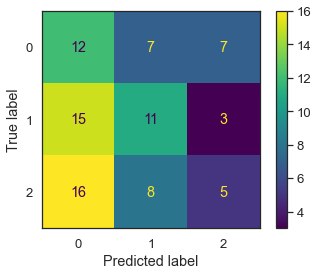

In [485]:
knn(x_train, y_train, x_test, y_test, 5)

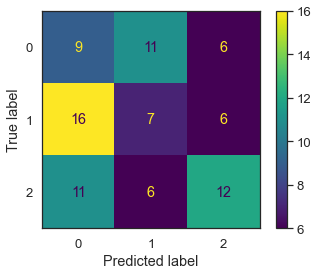

In [486]:
rf(x_train, y_train, x_test, y_test, 5)

In [487]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


features_tensor = torch.tensor(all_features, dtype=torch.float32)
labels_tensor = torch.tensor(all_signals_labels, dtype=torch.long).squeeze()
print("feature shape:", features_tensor.shape)
print("label shape:", labels_tensor.shape)
print("Unique encoded labels:", np.unique(all_signals_labels))

tensor_dataset = TensorDataset(features_tensor, labels_tensor)
train_dataset, test_dataset = train_test_split(tensor_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

feature shape: torch.Size([420, 128])
label shape: torch.Size([420])
Unique encoded labels: [0. 1. 2.]


In [488]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(128, 32)
        self.r1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(32, 8)
        self.r2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(8, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.r1(out)
        out = self.fc2(out)
        out = self.r2(out)
        out = self.fc3(out)
        # out = self.r3(out)
        # out = self.fc4(out)
        return out

model = SimpleNN()

In [489]:
import torch.optim as optim

epochs = 2000
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 22.71225037358024
Epoch 2, Loss: 2.753661708398299
Epoch 3, Loss: 1.4690733497793025
Epoch 4, Loss: 1.45241980119185
Epoch 5, Loss: 1.4013051769950173
Epoch 6, Loss: 1.2400719144127585
Epoch 7, Loss: 1.182447769425132
Epoch 8, Loss: 1.1380561048334294
Epoch 9, Loss: 1.1194220564582131
Epoch 10, Loss: 1.1174705570394343
Epoch 11, Loss: 1.1034491604024714
Epoch 12, Loss: 1.1006680943749168
Epoch 13, Loss: 1.1021911989558826
Epoch 14, Loss: 1.1174007762562146
Epoch 15, Loss: 1.0992745052684436
Epoch 16, Loss: 1.0885969942266291
Epoch 17, Loss: 1.0892304182052612
Epoch 18, Loss: 1.0917553359811956
Epoch 19, Loss: 1.0907208052548496
Epoch 20, Loss: 1.094782374121926
Epoch 21, Loss: 1.1082833463495427
Epoch 22, Loss: 1.0922501629049128
Epoch 23, Loss: 1.1006652170961553
Epoch 24, Loss: 1.1054183678193525
Epoch 25, Loss: 1.1040597341277383
Epoch 26, Loss: 1.0833893797614358
Epoch 27, Loss: 1.1139533844861118
Epoch 28, Loss: 1.072441816329956
Epoch 29, Loss: 1.0642246983268044
E

In [490]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train data: {100 * correct // total}%')

Accuracy of the network on the train data: 93%


In [491]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test data: {100 * correct // total}%')

Accuracy of the network on the test data: 32%
